In [10]:
# We will pull out the weekly values for a specific stock, in this case NOBL

# Import requests to access the API
import requests
from dask.dataframe.dispatch import tolist

# Create a variable for the API
stock_api = 'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol=NOBL&apikey=<Enter your Key Here>'

# Get the data
market_response = requests.get(stock_api)

# Define it as a JSON object
data = market_response.json()

# Specify the section we want to use
weekly_data = data["Weekly Time Series"]

# Create a list to populate 
new_list = []

# Populate the list with sub-lists for each week
for i, (date, values) in enumerate(weekly_data.items()):
	high = float(values['2. high'])
	low = float(values['3. low'])
	new_list.append([date, high, low])

# Check everything works
print(new_list)

[['2024-11-22', 107.0892, 104.27], ['2024-11-15', 107.415, 105.02], ['2024-11-08', 107.35, 103.5028], ['2024-11-01', 105.73, 103.44], ['2024-10-25', 108.08, 104.65], ['2024-10-18', 108.385, 106.15], ['2024-10-11', 106.51, 104.62], ['2024-10-04', 106.8899, 105.0574], ['2024-09-27', 107.29, 105.265], ['2024-09-20', 106.53, 105.11], ['2024-09-13', 105.33, 102.15], ['2024-09-06', 104.83, 102.7909], ['2024-08-30', 104.85, 103.15], ['2024-08-23', 103.671, 101.57], ['2024-08-16', 101.5, 99.03], ['2024-08-09', 100.74, 98.496], ['2024-08-02', 102.31, 99.45], ['2024-07-26', 100.89, 98.4822], ['2024-07-19', 101.34, 98.0299], ['2024-07-12', 98.6426, 95.06], ['2024-07-05', 96.68, 94.83], ['2024-06-28', 98.98, 95.76], ['2024-06-21', 97.99, 95.96], ['2024-06-14', 97.68, 95.655], ['2024-06-07', 98.225, 96.82], ['2024-05-31', 98.17, 95.72], ['2024-05-24', 100.34, 97.65], ['2024-05-17', 100.34, 99.195], ['2024-05-10', 99.84, 97.64], ['2024-05-03', 97.91, 96.48], ['2024-04-26', 98.1, 96.64], ['2024-04-19

In [11]:
# Create a dataframe from the list to organize the information for further processing

# Import Pandas
import pandas as pd

# List to dataframe
d_frame = pd.DataFrame(new_list, columns=['Date', 'High', 'Low'])

# Check everything works
d_frame.head()

,Date,High,Low
0,2024-11-22,107.0892,104.2700
1,2024-11-15,107.4150,105.0200
2,2024-11-08,107.3500,103.5028
3,2024-11-01,105.7300,103.4400
4,2024-10-25,108.0800,104.6500


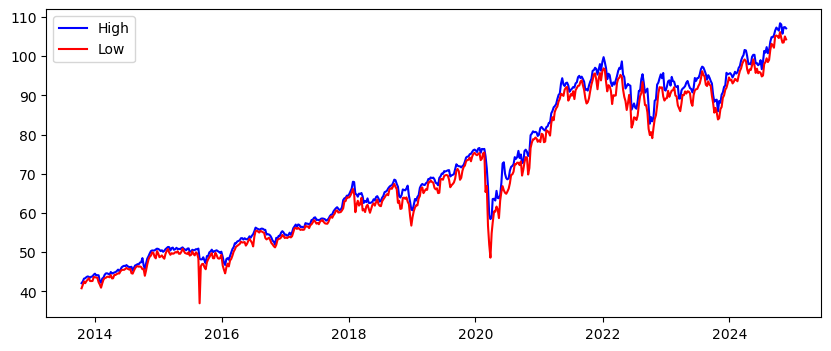

In [12]:
# Create plots of the data to see what it looks like visually

# import matplotlib
import matplotlib.pyplot as plt

# Define the variables to plot from the dataframe
date = d_frame['Date']
high = d_frame['High']
low = d_frame['Low']

# Convert Date column to date-time 
d_frame['Date'] = pd.to_datetime(d_frame['Date'])

# Set date as index to make plotting easier
d_frame.set_index('Date', inplace=True)

# Build out the plot
plt.figure(figsize=(10, 4))

# Plot the data
plt.plot(d_frame.index, d_frame['High'], label='High', color='blue')
plt.plot(d_frame.index, d_frame['Low'], label='Low', color='red')

# Add legend and title for readability of the plot's information
plt.legend()
plt.savefig('plot.png', bbox_inches='tight')

# Display the plot
plt.show()

#### Approach 1: Cross correlate all the data
ref: https://www.geeksforgeeks.org/cross-correlation-analysis-in-python/
<br></br>

#### Approach 2: Create vectors with just '52' week highs
Get data to analyse
- Create a vector with the first 52 values
- For each high, create a vector with 52 values preceding it
- If it's the highest value in the vector keep it
- Build the next vector with 52 values and repeat the procedure
- If it's not the highest, select the highest
- Then select the next 52 and repeat
- Build a new vector with the highest scores and their index
- Build a corresponding set of lows at +1 week
- Do the same for lows, but replace 'high' with 'low'
- Build a corresponding set of highs at +1 week
- Cross correlate the data 
<br></br>
#### Approach 3: Procedure to identify highs and lows
- For each new value, build an array of the preceding 52 values
- If it's not the highest, do nothing
- If it is the highest, add it to a list, with the corresponding date
- Notify that there is a high


In [19]:
# Manual cross correlation
# Pls. not, the computation here comes from the tutorial provided in the Geeks for Geeks tutorial linked above.
# I am just testing out here for my own education

# Import libraries
import numpy as np
import math

# Identify our two series and create a lag between them of one week
array_x = np.array(high[:-1]).tolist()  # High from start to end
array_y = np.array(high[2:]).tolist()  # Low from third week to end

# Function to calculate the mean
def mean(arr):
	return sum(arr)/len(arr)

# Next we will define the correlation
def crs_corr(x, y):
	x_mean = mean(x)  # Python assigns array_x to x and calc mean
	y_mean = mean(y)  # Python assigns array_y to y and calc mean
	
	# Cross correlation numerator
	# In the line of code below, each element of each array has the mean subtracted from it
	# This is done for each a and b
	# They are paired and multiplied
	num = sum((a - x_mean) * (b - y_mean) for a, b in zip(x, y))
	
	# The denominator
	# The differences for x are squared
	x_sq_diff = sum((a - x_mean) ** 2 for a in x)
	
	# The differences for y are squared
	y_sq_diff = sum((b - y_mean) ** 2 for b in y)
	
	# We construct the denominator
	denominator = math.sqrt(x_sq_diff * y_sq_diff)
	
	# We compute the correlation
	corr = num / denominator
	return corr

# Call the functions and compute
correlation = crs_corr(array_x, array_y)
print('Correlation:', correlation)

Correlation: 0.9934372803099548


In [24]:
# Doing the same thing with numpy and with scipy

# With numpy
# Note, for x we are slicing off the end to allow the arrays to match
array_x_np = np.array(high[:-2])  # High from start to end
array_y_np = np.array(high[2:])  # Low from third week to end

print(array_x_np.shape, array_y_np.shape)  # Check the shapes match
numpy_correlation = np.corrcoef(array_x_np, array_y_np)[0, 1]
print('NumPy Correlation:', numpy_correlation)

# Now with SciPy
from scipy.stats import pearsonr
scipy_correlation, _ = pearsonr(array_x_np, array_y_np)
print('SciPy Correlation:', scipy_correlation)


(578,) (578,)
NumPy Correlation: 0.9954276019831423
SciPy Correlation: 0.9954276019831418
